## 0. Loading Packages

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
import git
from pathlib import Path
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 1. Select transform type and group

In [2]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 3
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

CATEGORY_NAME = categories[group]
GROUP_NAMES = groups[group]

# Suffix used to construct internal filenames
transform_affix = 'cwt-small'

KS_THRESHOLD = 0.05  

# --- Path Definitions ---
DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')
PATHS = {
    "Original-Pitch": {
        "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}_freqs.npy')
    }
    # "Pitch-Normalized": {
    #     "coefs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_coefs.npz'),
    #     "freqs_path": os.path.join(DATA_DIR, f'{transform_affix}-pn_freqs.npy')
    # }
}

print("✅ Loaded successfully.")
print(f"Analysis Category: {CATEGORY_NAME.replace('_', ' ').title()} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]})")
print(f"KS Test Decision Threshold: {KS_THRESHOLD}")

✅ Loaded successfully.
Analysis Category: Emotional Intensity (normal_intensity vs strong_intensity)
KS Test Decision Threshold: 0.05


## 2. Analysis Functions

In [3]:
def preprocess_and_save_by_band(coefs_npz_path, unified_bands_indices, temp_dir, group_id, group_map):
    print(f"  - Step 1: Pre-processing and sharding data by band to: {temp_dir}")
    
    current_group_names = group_map[group_id]
    
    file_writers = {}
    for i, _ in enumerate(unified_bands_indices):
        file_writers[i] = {}
        for group_name in current_group_names:
            temp_file_path = temp_dir / f"band_{i}_{group_name}.bin"
            file_writers[i][group_name] = open(temp_file_path, 'wb')

    with np.load(coefs_npz_path, allow_pickle=True) as data:
        total_files = len(data.files)
        print(f"  - Found {total_files} files in NPZ archive. Starting sharding...")
        for i, item in enumerate(data.files):
            if (i + 1) % 200 == 0:
                print(f"    - Sharding file {i+1}/{total_files}...")
            
            try:
                base_filename = item.split('_')[0]
                actor_id = int(base_filename.split('-')[group_id])
                group_label = current_group_names[1] if actor_id % 2 == 0 else current_group_names[0]
                
                coeffs = data[item]
                if coeffs.size == 0 or coeffs.ndim != 2:
                    continue

                num_freqs = coeffs.shape[0]

                for band_idx, (start_idx, end_idx) in enumerate(unified_bands_indices):
                    if start_idx < num_freqs:
                        band_coeffs = coeffs[start_idx:end_idx, :]
                        if band_coeffs.size > 0:
                            file_writers[band_idx][group_label].write(band_coeffs.astype(np.complex64).tobytes())

            except (ValueError, IndexError) as e:
                print(f"  - Warning: Could not parse filename '{item}', skipped. Error: {e}")
                continue
    for band_idx in file_writers:
        for group_name in file_writers[band_idx]:
            file_writers[band_idx][group_name].close()
    
    print("  - Pre-processing and sharding complete.")


def compare_distributions_from_files(temp_dir, unified_bands_indices, group_names):
    print(f"  - Step 2: Performing KS test band by band from sharded files...")
    
    group1_name, group2_name = group_names[0], group_names[1]
    results = []

    for i, (start_idx, end_idx) in enumerate(unified_bands_indices):
        try:
            path_g1 = temp_dir / f"band_{i}_{group1_name}.bin"
            path_g2 = temp_dir / f"band_{i}_{group2_name}.bin"

            if not path_g1.exists() or not path_g2.exists() or path_g1.stat().st_size == 0 or path_g2.stat().st_size == 0:
                continue

            group1_coeffs = np.fromfile(path_g1, dtype=np.complex64)
            group2_coeffs = np.fromfile(path_g2, dtype=np.complex64)

            if len(group1_coeffs) < 30 or len(group2_coeffs) < 30:
                continue
            
            ks_stat_real, _ = ks_2samp(np.real(group1_coeffs), np.real(group2_coeffs))
            ks_stat_imag, _ = ks_2samp(np.imag(group1_coeffs), np.imag(group2_coeffs))
            
            results.append({
                'band_indices': f'{start_idx}-{end_idx - 1}' if end_idx > start_idx + 1 else str(start_idx),
                'ks_stat_real': ks_stat_real,
                'ks_stat_imag': ks_stat_imag,
            })
        except Exception as e:
            print(f"  - Warning: Could not process band {i}. Error: {e}")
            continue
            
    print("  - Band-by-band comparison complete.")
    return pd.DataFrame(results)

def load_single_group_by_band(coefs_npz_path: str,
                              unified_bands_indices: list,
                              group_id: int,
                              group_map: dict,
                              category_map: dict,
                              target_group: str):
    print(f"  - Loading data for target group '{target_group}' from: {os.path.basename(coefs_npz_path)}")
    group_names = group_map[group_id]

    processed_data = {
        target_group: {
            (f'{start}-{end - 1}' if end > start + 1 else str(start)): {'real': [], 'imag': []}
            for start, end in unified_bands_indices
        }
    }

    freq_to_band_map = {}
    for start, end in unified_bands_indices:
        band_label = f'{start}-{end - 1}' if end > start + 1 else str(start)
        for freq_idx in range(start, end):
            freq_to_band_map[freq_idx] = band_label

    with np.load(coefs_npz_path, allow_pickle=True) as data:
        total_files = len(data.files)
        print(f"  - Scanning {total_files} files, collecting for '{target_group}'...")
        processed_count = 0
        for i, item in enumerate(data.files):
            try:
                base_filename = item.split('_')[0]
                actor_id = int(base_filename.split('-')[group_id])
                group_label = group_names[1] if actor_id % 2 == 0 else group_names[0]

                if group_label != target_group:
                    continue
                
                processed_count += 1
                if processed_count % 200 == 0:
                    print(f"    - Found and processed {processed_count} files for '{target_group}'...")

                coeffs = data[item]

                if coeffs.ndim == 2:  # 2D array (e.g., STFT)
                    for freq_idx in range(coeffs.shape[0]):
                        band_label = freq_to_band_map.get(freq_idx)
                        if band_label:
                            target_list_real = processed_data[target_group][band_label]['real']
                            target_list_imag = processed_data[target_group][band_label]['imag']
                            target_list_real.extend(np.real(coeffs[freq_idx, :]))
                            target_list_imag.extend(np.imag(coeffs[freq_idx, :]))

                elif coeffs.ndim == 1: # 1D array
                    if coeffs.dtype == object:  # Jagged array (e.g., CWT/Erblet)
                        for freq_idx, inner_array in enumerate(coeffs):
                            band_label = freq_to_band_map.get(freq_idx)
                            if band_label and hasattr(inner_array, '__iter__'):
                                target_list_real = processed_data[target_group][band_label]['real']
                                target_list_imag = processed_data[target_group][band_label]['imag']
                                target_list_real.extend(np.real(inner_array))
                                target_list_imag.extend(np.imag(inner_array))
                    else: # Standard 1D array (e.g., FFT)
                         for freq_idx, coeff_val in enumerate(coeffs):
                            band_label = freq_to_band_map.get(freq_idx)
                            if band_label:
                                processed_data[target_group][band_label]['real'].append(np.real(coeff_val))
                                processed_data[target_group][band_label]['imag'].append(np.imag(coeff_val))

            except (ValueError, IndexError) as e:
                print(f"  - Warning: Could not parse filename '{item}', skipped. Error: {e}")
                continue

    print(f"  - Data collection complete for '{target_group}'. Converting lists to NumPy arrays...")
    for band_label, data_dict in processed_data[target_group].items():
        if data_dict['real']:
            data_dict['real'] = np.array(data_dict['real'])
            data_dict['imag'] = np.array(data_dict['imag'])
        else:
            data_dict['real'] = np.array([])
            data_dict['imag'] = np.array([])

    return processed_data

## 3. Distribution Analysis

In [4]:
all_results = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: Cannot find file {paths['coefs_path']} or {paths['freqs_path']}. Skipping experiment.")
        all_results[experiment_name] = pd.DataFrame()
        continue

    temp_dir_path = pathlib.Path(tempfile.mkdtemp())
    print(f"  - Created temporary directory: {temp_dir_path}")

    try:
        unified_band_indices = freq_band_groupings(
            coefs_npz_path=paths["coefs_path"],
            ks_threshold=KS_THRESHOLD,
            batch_size=6,
            subsample_every=6,
            presplit_depth=1
        )
        print(f"  - Unified banding complete. Found {len(unified_band_indices)} bands.")
        
        preprocess_and_save_by_band(
            coefs_npz_path=paths["coefs_path"],
            unified_bands_indices=unified_band_indices,
            temp_dir=temp_dir_path,
            group_id=group,
            group_map=groups
        )

        comparison_df = compare_distributions_from_files(
            temp_dir=temp_dir_path,
            unified_bands_indices=unified_band_indices,
            group_names=GROUP_NAMES
        )
        
        all_results[experiment_name] = comparison_df

    except Exception as e:
        print(f"❗️❗️ An unexpected error occurred during experiment '{experiment_name}': {e}")
    finally:
        print(f"  - Cleaning up temporary directory: {temp_dir_path}")
        shutil.rmtree(temp_dir_path)

    print(f"✅ Experiment {experiment_name} complete.")

print("\n\n--- All Experiments Finished ---")


==================== Starting Experiment: Original-Pitch ====================
  - Created temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp81iggdj4
  - Unified banding complete. Found 10 bands.
  - Step 1: Pre-processing and sharding data by band to: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp81iggdj4
  - Found 1440 files in NPZ archive. Starting sharding...
    - Sharding file 200/1440...
    - Sharding file 400/1440...
    - Sharding file 600/1440...
    - Sharding file 800/1440...
    - Sharding file 1000/1440...
    - Sharding file 1200/1440...
    - Sharding file 1400/1440...
  - Pre-processing and sharding complete.
  - Step 2: Performing KS test band by band from sharded files...
  - Band-by-band comparison complete.
  - Cleaning up temporary directory: /var/folders/73/sgjz9s7d6b318g3bz68k4lnr0000gn/T/tmp81iggdj4
✅ Experiment Original-Pitch complete.

==================== Starting Experiment: Pitch-Normalized ====================
  - Created tem

## 4. Results and Visualization


############################################################
### Analysis Report: Emotional Intensity ###
############################################################

--- Results for: Original-Pitch (normal_intensity vs strong_intensity) ---
In 10 bands, 0 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
        0-16         0.045         0.045
       17-20         0.026         0.026
       21-22         0.028         0.028
          23         0.030         0.030
       24-25         0.031         0.031
       26-29         0.023         0.023
       30-31         0.019         0.019
          32         0.019         0.019
          33         0.021         0.016
          34         0.020         0.016


--- Results for: Pitch-Normalized (normal_intensity vs strong_intensity) ---
In 17 bands, 2 have a difference greater than the threshold 0.05.
band_indices  ks_stat_real  ks_stat_imag
         0-3         0.024         0.024
           4

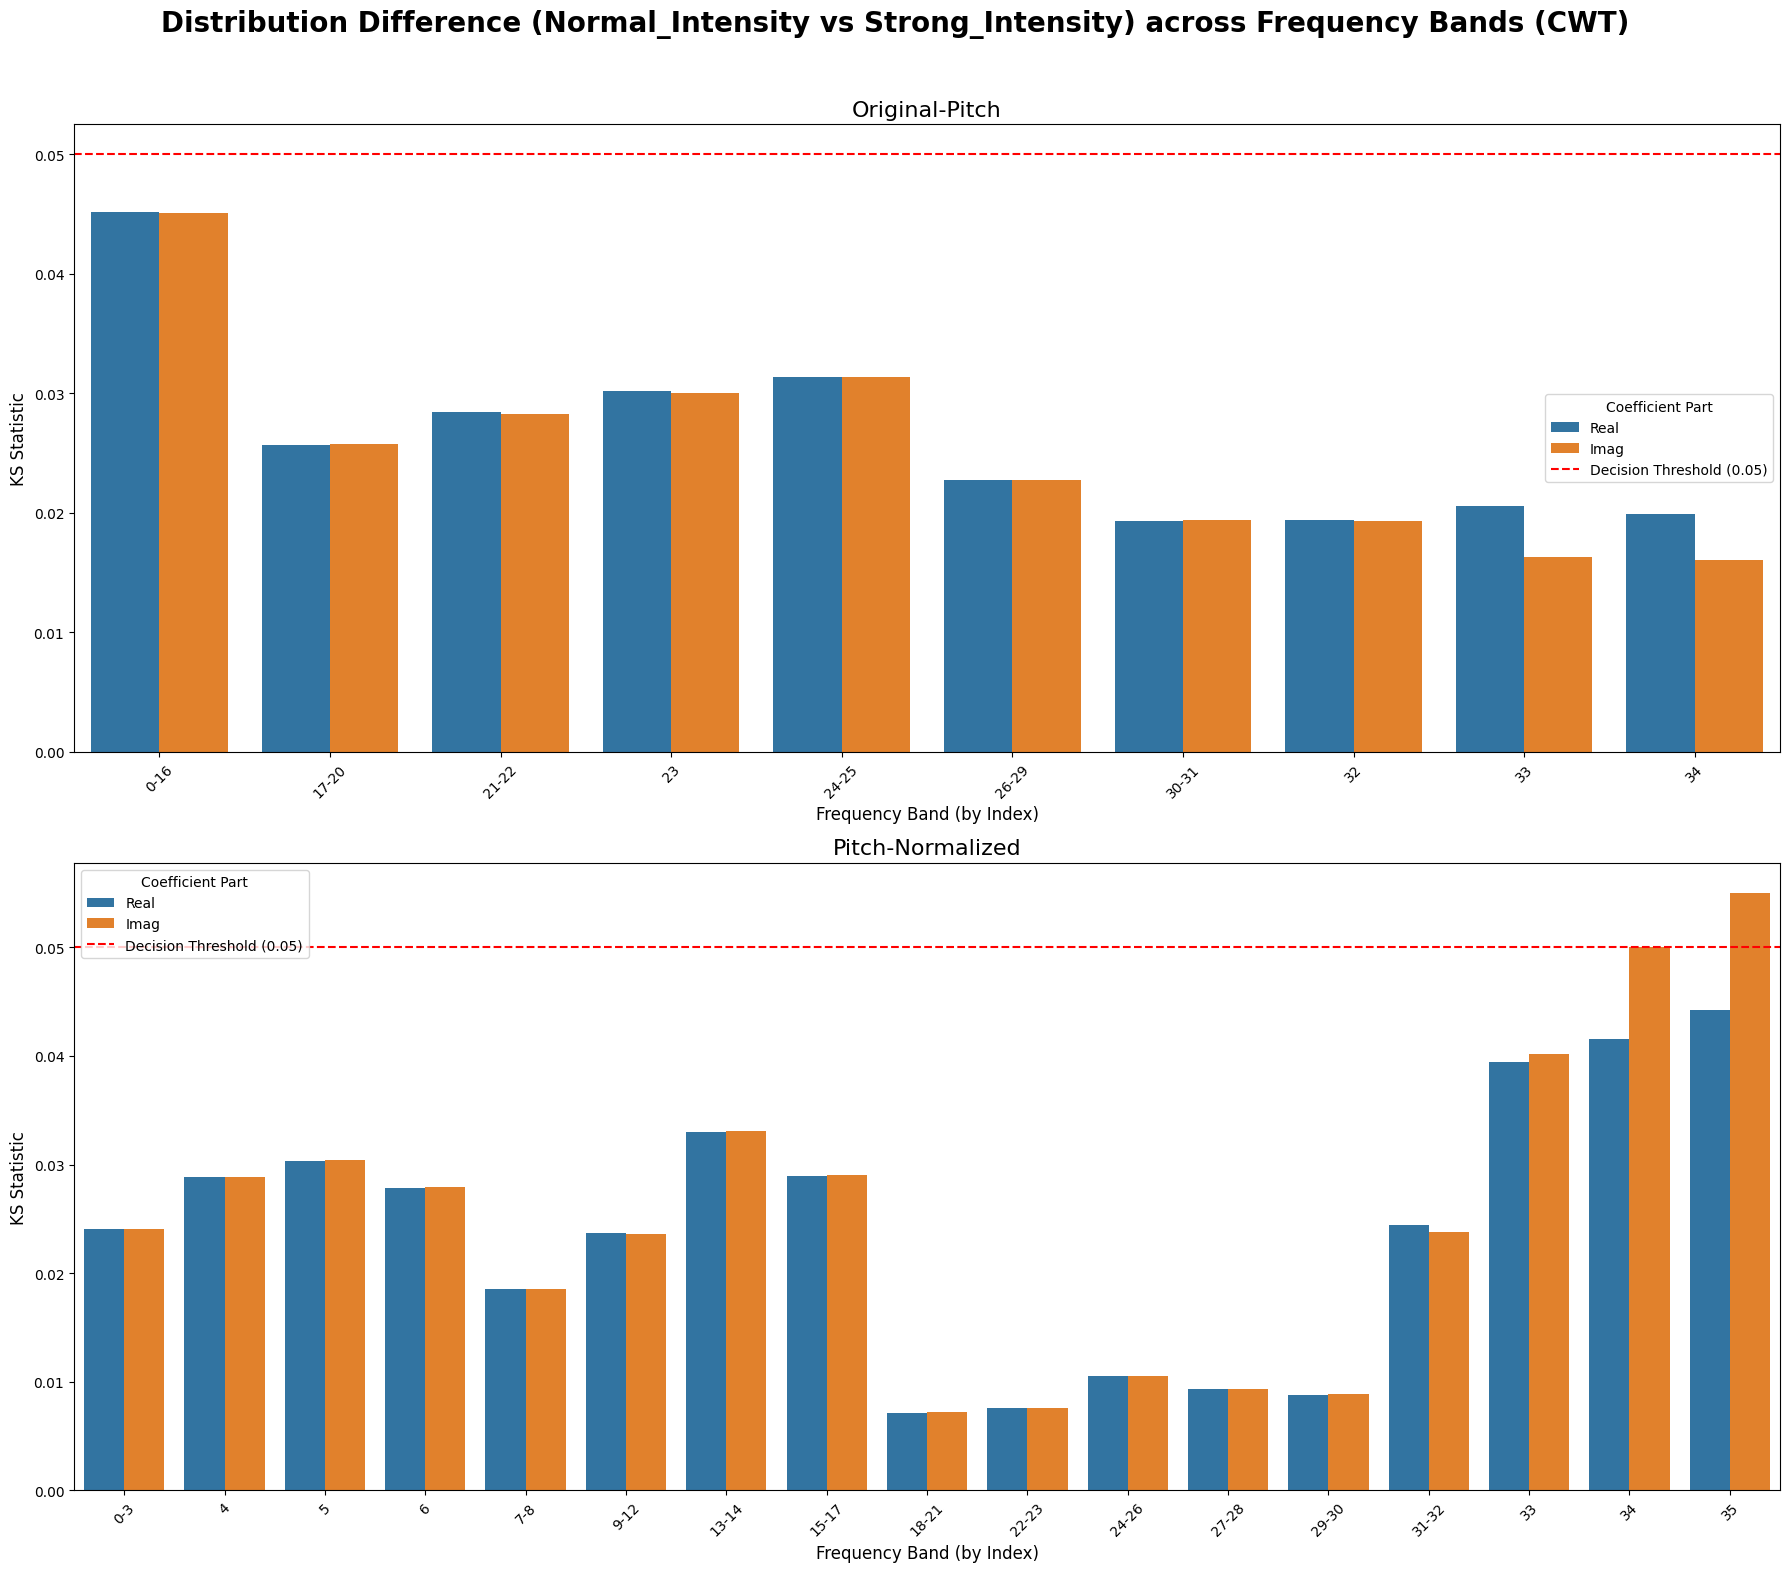

In [5]:
if not all_files_exist:
    print("\n❗️Analysis could not be completed due to missing files. Cannot generate report.")
else:
    print("\n" + "#"*60)
    print(f"### Analysis Report: {CATEGORY_NAME.replace('_', ' ').title()} ###")
    print("#"*60 + "\n")
    
    for experiment_name, result_df in all_results.items():
        print(f"--- Results for: {experiment_name} ({GROUP_NAMES[0]} vs {GROUP_NAMES[1]}) ---")
        if result_df.empty:
            print("  - No results to display for this experiment.")
            continue
        
        significant_diffs = result_df[
            (result_df['ks_stat_real'] > KS_THRESHOLD) | 
            (result_df['ks_stat_imag'] > KS_THRESHOLD)
        ]
        print(f"In {len(result_df)} bands, {len(significant_diffs)} have a difference greater than the threshold {KS_THRESHOLD}.")
        print(result_df.round(3).to_string(index=False))
        print("\n")

    # --- Visualization ---
    fig, axes = plt.subplots(len(all_results), 1, figsize=(18, 8 * len(all_results)), sharex=False)
    if len(all_results) == 1: axes = [axes]
    fig.suptitle(f'Distribution Difference ({GROUP_NAMES[0].title()} vs {GROUP_NAMES[1].title()}) across Frequency Bands ({transform_affix.upper()})', fontsize=20, weight='bold')

    for ax, (experiment_name, result_df) in zip(axes, all_results.items()):
        if result_df.empty:
            ax.text(0.5, 0.5, 'No data to plot for this experiment.', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(experiment_name, fontsize=16)
            continue
        
        plot_df = result_df.melt(
            id_vars=['band_indices'], 
            value_vars=['ks_stat_real', 'ks_stat_imag'],
            var_name='Coefficient Part',
            value_name='KS Statistic'
        )
        plot_df['Coefficient Part'] = plot_df['Coefficient Part'].str.replace('ks_stat_', '').str.title()
        
        # Create the bar plot
        sns.barplot(ax=ax, data=plot_df, x='band_indices', y='KS Statistic', hue='Coefficient Part')
        
        # Add the decision threshold line
        ax.axhline(y=KS_THRESHOLD, color='r', linestyle='--', label=f'Decision Threshold ({KS_THRESHOLD})')
        
        ax.set_title(experiment_name, fontsize=16)
        ax.set_xlabel('Frequency Band (by Index)', fontsize=12)
        ax.set_ylabel('KS Statistic', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Coefficient Part')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## 5. Unified Bands & Subdivision (Raw)

In [4]:
all_subdivided_data = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: File not found {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Step 1: Calculating unified frequency bands on all data...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        batch_size=20,
        subsample_every=5,
        ks_threshold=KS_THRESHOLD,
        presplit_depth=5
    )
    print(f"  - Unified band division complete. Found {len(unified_band_indices)} bands in total.")
    
    
# --- Step 2: Loop through each group and save them separately ---
    print(f"\n{'='*20} Processing and Saving Data by Group {'='*20}")
    
    for group_name in GROUP_NAMES: # For example: first loop group_name = 'male', second = 'female'
        print(f"\n--- Processing group: {group_name} ---")
        
        single_group_data = load_single_group_by_band(
            coefs_npz_path=paths["coefs_path"],
            unified_bands_indices=unified_band_indices,
            group_id=group,
            group_map=groups,
            category_map=categories,
            target_group=group_name
        )
        
        output_filename = f'ravdess_{experiment_name}_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_{group_name}.pickle'
        print(f"  - Saving data for '{group_name}' to: {output_filename} ...")

        # Save the Pickle file for the current group
        with open(output_filename, 'wb') as file:
            final_output_structure = {
                experiment_name: single_group_data
            }
            pickle.dump(final_output_structure, file)

        print(f"✅ Data for group '{group_name}' saved successfully!")

if not all_files_exist:
    print("\n❗️No output file was generated due to missing files.")
else:
    print("\n✅ All processing complete. Separate pickle files have been generated for each group.")


==================== Starting Experiment: Original-Pitch ====================
  - Step 1: Calculating unified frequency bands on all data...
  - Unified band division complete. Found 32 bands in total.

==================== Processing and Saving Data by Group ====================

--- Processing group: normal_intensity ---
  - Loading data for target group 'normal_intensity' from: cwt-small_coefs.npz
  - Scanning 1440 files, collecting for 'normal_intensity'...
    - Found and processed 200 files for 'normal_intensity'...
    - Found and processed 400 files for 'normal_intensity'...
    - Found and processed 600 files for 'normal_intensity'...
  - Data collection complete for 'normal_intensity'. Converting lists to NumPy arrays...
  - Saving data for 'normal_intensity' to: ravdess_Original-Pitch_cwt-small_emotional_intensity_normal_intensity.pickle ...
✅ Data for group 'normal_intensity' saved successfully!

--- Processing group: strong_intensity ---
  - Loading data for target group 

In [4]:
all_subdivided_data = {}
all_files_exist = True

for experiment_name, paths in PATHS.items():
    print(f"\n{'='*20} Starting Experiment: {experiment_name} {'='*20}")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"❗️Error: File not found {paths['coefs_path']} or {paths['freqs_path']}.")
        all_files_exist = False
        break

    print("  - Step 1: Calculating unified frequency bands on all data...")
    unified_band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        batch_size=20,
        subsample_every=5,
        ks_threshold=KS_THRESHOLD,
        presplit_depth=5
    )
    print(f"  - Unified band division complete. Found {len(unified_band_indices)} bands in total.")


==================== Starting Experiment: Original-Pitch ====================
  - Step 1: Calculating unified frequency bands on all data...
  - Unified band division complete. Found 32 bands in total.


In [5]:
group_name = 'strong_intensity'

print(f"\n--- Processing group: {group_name} ---")

single_group_data = load_single_group_by_band(
    coefs_npz_path=paths["coefs_path"],
    unified_bands_indices=unified_band_indices,
    group_id=group,
    group_map=groups,
    category_map=categories,
    target_group=group_name
)

output_filename = f'ravdess_{experiment_name}_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_{group_name}.pickle'
print(f"  - Saving data for '{group_name}' to: {output_filename} ...")

with open(output_filename, 'wb') as file:
    final_output_structure = {
        experiment_name: single_group_data
    }
    pickle.dump(final_output_structure, file)

print(f"✅ Data for group '{group_name}' saved successfully!")


--- Processing group: strong_intensity ---
  - Loading data for target group 'strong_intensity' from: cwt-small_coefs.npz
  - Scanning 1440 files, collecting for 'strong_intensity'...
    - Found and processed 200 files for 'strong_intensity'...
    - Found and processed 400 files for 'strong_intensity'...
    - Found and processed 600 files for 'strong_intensity'...
  - Data collection complete for 'strong_intensity'. Converting lists to NumPy arrays...
  - Saving data for 'strong_intensity' to: ravdess_Original-Pitch_cwt-small_emotional_intensity_strong_intensity.pickle ...
✅ Data for group 'strong_intensity' saved successfully!


## 6. Load and verify the saved pickle file (Optional)

In [ ]:
try:
    print(f"\n{'='*20} Verifying the Saved Files {'='*20}")

    for group_name in GROUP_NAMES:
        verify_filename = f'ravdess_{experiment_name}_{transform_affix}_{CATEGORY_NAME.replace(" ", "_")}_{group_name}.pickle'
        print(f"\n--- Verifying file for group: '{group_name}' ---")
        print(f"  - Attempting to load: {verify_filename}")

        # 1. Load the specific pickle file for this group
        with open(verify_filename, 'rb') as file:
            loaded_data = pickle.load(file)
        
        print("  - File loaded successfully! Checking structure...")

        # The top-level key is the experiment name
        first_experiment = list(loaded_data.keys())[0]

        if group_name in loaded_data[first_experiment]:
            print(f"  - Found group key '{group_name}' as expected.")
        else:
            print(f"  - ❗️Verification Error: Did not find group key '{group_name}'!")
            continue # Move to the next file

        # Check the band labels under the current group
        band_labels = list(loaded_data[first_experiment][group_name].keys())
        print(f"  - Found {len(band_labels)} band labels under '{group_name}'. First 5: {band_labels[:5]}")

        first_band = band_labels[0]
        real_coeffs = loaded_data[first_experiment][group_name][first_band]['real']
        print(f"  - Data check inside '{first_band}' -> 'real': Found Numpy array with shape {real_coeffs.shape}")
        print(f"✅ Verification PASSED for group '{group_name}'.")

except FileNotFoundError as e:
    print(f"\n❗️Verification FAILED: Cannot find a required file.")
    print(f"  - Error details: {e}")
    print(f"  - Please ensure the main processing loop has run successfully for all groups.")
except Exception as e:
    print(f"\n❗️An unknown error occurred during verification: {e}")